In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from pmdarima.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # 各評価指標

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
df=pd.read_csv('dataset.csv',                         
               index_col='cdr_date',           
               parse_dates=True)     
df.head() 

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,...,cos7_3,sin7_4,cos7_4,sin7_5,cos7_5,sin7_6,cos7_6,sin7_7,cos7_7,t
cdr_date,,,,,,,,,,,,,,,,,,,,,
2018-06-09,-0.801105,-0.297227,-0.569686,-0.743068,-0.035384,-0.035384,0,8,6,23,...,1.000000,-9.797174e-16,1.000000,-1.224647e-15,1.000000,-1.469576e-15,1.000000,-1.714506e-15,1.0,0
2018-06-10,0.000000,-0.421072,-0.297227,-0.049538,0.028307,-0.068115,0,8,7,23,...,-0.900969,-4.338837e-01,-0.900969,-9.749279e-01,-0.222521,-7.818315e-01,0.623490,-1.959435e-15,1.0,1
2018-06-11,1.468692,0.978373,-0.421072,0.854528,-0.024769,-0.107332,0,8,1,24,...,0.623490,7.818315e-01,0.623490,4.338837e-01,-0.900969,-9.749279e-01,-0.222521,-2.204364e-15,1.0,2
2018-06-12,-0.567449,-0.185767,0.978373,-0.210536,-0.007077,0.001238,0,8,2,24,...,-0.222521,-9.749279e-01,-0.222521,7.818315e-01,0.623490,-4.338837e-01,-0.900969,-2.449294e-15,1.0,3
2018-06-13,0.250345,0.359150,-0.185767,0.136229,-0.003538,-0.015762,0,8,3,24,...,-0.222521,9.749279e-01,-0.222521,-7.818315e-01,0.623490,4.338837e-01,-0.900969,4.411204e-15,1.0,4


In [3]:
#三角特徴量がないほうが精度が高いと判明
#三角特徴量を除く
df = df[['call_num', 'acc_get_cnt', 'acc_get_cnt_lag1', 'acc_get_cnt_lag7', 'acc_get_cnt_window7', 'acc_get_cnt_expanding', 
          'cm_flg', 'cm_cumsum', 'dow', 'woy', 'wom', 'doy', 'day_before_holiday_flag', 'holiday_flag', 'search_trend' ,'search_cnt', 'isSunday', 't' ]]

In [4]:
df.isnull().sum()

call_num                   0
acc_get_cnt                0
acc_get_cnt_lag1           0
acc_get_cnt_lag7           0
acc_get_cnt_window7        0
acc_get_cnt_expanding      0
cm_flg                     0
cm_cumsum                  0
dow                        0
woy                        0
wom                        0
doy                        0
day_before_holiday_flag    0
holiday_flag               0
search_trend               0
search_cnt                 0
isSunday                   0
t                          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 662 entries, 2018-06-09 to 2020-03-31
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_num                 662 non-null    float64
 1   acc_get_cnt              662 non-null    float64
 2   acc_get_cnt_lag1         662 non-null    float64
 3   acc_get_cnt_lag7         662 non-null    float64
 4   acc_get_cnt_window7      662 non-null    float64
 5   acc_get_cnt_expanding    662 non-null    float64
 6   cm_flg                   662 non-null    int64  
 7   cm_cumsum                662 non-null    int64  
 8   dow                      662 non-null    int64  
 9   woy                      662 non-null    int64  
 10  wom                      662 non-null    int64  
 11  doy                      662 non-null    int64  
 12  day_before_holiday_flag  662 non-null    bool   
 13  holiday_flag             662 non-null    bool   
 14  search_

In [6]:
#直近3ヶ月をテストデータにする
train, test = train_test_split(df, test_size=91)

In [7]:
train.head()

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,wom,doy,day_before_holiday_flag,holiday_flag,search_trend,search_cnt,isSunday,t
cdr_date,,,,,,,,,,,,,,,,,,
2018-06-09,-0.801105,-0.297227,-0.569686,-0.743068,-0.035384,-0.035384,0,8,6,23,2,160,True,True,27.0,18.0,0,0
2018-06-10,0.000000,-0.421072,-0.297227,-0.049538,0.028307,-0.068115,0,8,7,23,3,161,False,True,27.0,6.0,1,1
2018-06-11,1.468692,0.978373,-0.421072,0.854528,-0.024769,-0.107332,0,8,1,24,3,162,False,False,27.0,6.0,0,2
2018-06-12,-0.567449,-0.185767,0.978373,-0.210536,-0.007077,0.001238,0,8,2,24,3,163,False,False,27.0,6.0,0,3
2018-06-13,0.250345,0.359150,-0.185767,0.136229,-0.003538,-0.015762,0,8,3,24,3,164,False,False,27.0,6.0,0,4


In [8]:
train.tail()

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,wom,doy,day_before_holiday_flag,holiday_flag,search_trend,search_cnt,isSunday,t
cdr_date,,,,,,,,,,,,,,,,,,
2019-12-27,-0.233655,-0.037153,0.222920,-0.433456,-3.007657e-02,-0.000043,0,160,5,52,4,361,True,False,30.0,49.0,0,566
2019-12-28,-1.109864,-0.854528,-0.037153,-0.668761,2.653815e-02,-0.000108,0,160,6,52,4,362,True,True,30.0,49.0,0,567
2019-12-29,0.000000,0.086691,-0.854528,0.247689,1.586033e-17,-0.001594,0,160,7,52,5,363,False,True,30.0,16.0,1,568
2019-12-30,0.425587,-0.111460,0.086691,0.532532,-2.299973e-02,-0.001441,0,160,1,1,5,364,False,False,30.0,16.0,0,569
2019-12-31,-0.425587,-0.235305,-0.111460,-0.284843,-1.149987e-01,-0.001631,0,160,2,1,5,365,True,False,30.0,16.0,0,570


In [9]:
test.head()

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,wom,doy,day_before_holiday_flag,holiday_flag,search_trend,search_cnt,isSunday,t
cdr_date,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,-0.024769,-0.235305,0.173383,-0.107922,-0.002036,0,160,3,1,1,1,False,True,19.0,16.0,0,571
2020-01-02,0.000000,0.198152,-0.024769,0.222920,-0.136229,-0.002075,0,160,4,1,1,2,False,False,19.0,16.0,0,572
2020-01-03,0.216966,0.111460,0.198152,-0.037153,-0.139768,-0.001730,0,160,5,1,1,3,True,False,19.0,16.0,0,573
2020-01-04,-0.216966,0.210536,0.111460,-0.854528,-0.118537,-0.001535,0,160,6,1,1,4,True,True,19.0,16.0,0,574
2020-01-05,0.000000,-0.099076,0.210536,0.086691,0.033615,-0.001170,0,160,7,1,2,5,False,True,19.0,22.0,1,575


In [10]:
test.tail()

,call_num,acc_get_cnt,acc_get_cnt_lag1,acc_get_cnt_lag7,acc_get_cnt_window7,acc_get_cnt_expanding,cm_flg,cm_cumsum,dow,woy,wom,doy,day_before_holiday_flag,holiday_flag,search_trend,search_cnt,isSunday,t
cdr_date,,,,,,,,,,,,,,,,,,
2020-03-27,0.108483,0.185767,-0.099076,-0.718299,-0.024769,0.000951,1,203,5,13,4,87,True,False,23.0,25.0,0,657
2020-03-28,-1.059795,-0.755453,0.185767,-0.359150,0.104383,0.001229,1,204,6,13,4,88,True,True,23.0,25.0,0,658
2020-03-29,0.000000,-0.421072,-0.755453,0.074307,0.047769,0.000093,1,205,7,13,5,89,False,True,23.0,20.0,1,659
2020-03-30,1.118208,0.334381,-0.421072,0.817375,-0.023000,-0.000538,1,206,1,14,5,90,False,False,23.0,20.0,0,660
2020-03-31,-0.275380,0.953604,0.334381,0.173383,-0.091999,-0.000037,1,207,2,14,5,91,False,False,23.0,20.0,0,661


In [11]:
#アカウント獲得数を目的変数に設定
y_train = train['acc_get_cnt']    #目的変数y
X_train = train.drop('acc_get_cnt', axis=1) #説明変数X

y_test = test['acc_get_cnt']              #目的変数y
X_test = test.drop('acc_get_cnt', axis=1) #説明変数X

In [12]:
#データ量削減関数
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 71.5%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 72.3%


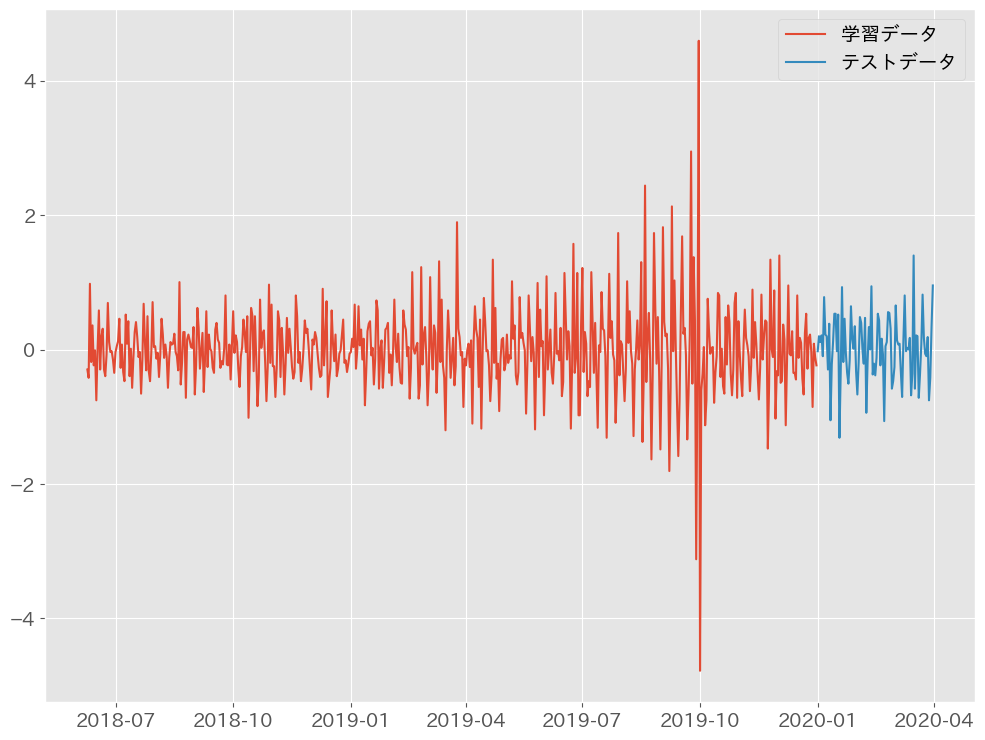

In [13]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="学習データ")
ax.plot(y_test.index, y_test.values, label="テストデータ")
plt.legend()

# Ridge回帰

In [14]:
regressor = RidgeCV(alphas=np.linspace(1, 10000000, 1000)/100, cv = 10)
regressor.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.00110090e+02, 2.00210180e+02, 3.00310270e+02,
       4.00410360e+02, 5.00510450e+02, 6.00610541e+02, 7.00710631e+02,
       8.00810721e+02, 9.00910811e+02, 1.00101090e+03, 1.10111099e+03,
       1.20121108e+03, 1.30131117e+03, 1.40141126e+03, 1.50151135e+03,
       1.60161144e+03, 1.70171153e+03, 1.80181162e+03, 1.90191171e+03,
       2.00201180e+03, 2.10211189e+0...
       9.76976979e+04, 9.77977980e+04, 9.78978981e+04, 9.79979982e+04,
       9.80980983e+04, 9.81981984e+04, 9.82982985e+04, 9.83983986e+04,
       9.84984986e+04, 9.85985987e+04, 9.86986988e+04, 9.87987989e+04,
       9.88988990e+04, 9.89989991e+04, 9.90990992e+04, 9.91991993e+04,
       9.92992994e+04, 9.93993995e+04, 9.94994995e+04, 9.95995996e+04,
       9.96996997e+04, 9.97997998e+04, 9.98998999e+04, 1.00000000e+05]),
        cv=10)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 571 entries, 2018-06-09 to 2019-12-31
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_num                 571 non-null    float16
 1   acc_get_cnt_lag1         571 non-null    float16
 2   acc_get_cnt_lag7         571 non-null    float16
 3   acc_get_cnt_window7      571 non-null    float16
 4   acc_get_cnt_expanding    571 non-null    float16
 5   cm_flg                   571 non-null    int8   
 6   cm_cumsum                571 non-null    int16  
 7   dow                      571 non-null    int8   
 8   woy                      571 non-null    int8   
 9   wom                      571 non-null    int8   
 10  doy                      571 non-null    int16  
 11  day_before_holiday_flag  571 non-null    float16
 12  holiday_flag             571 non-null    float16
 13  search_trend             571 non-null    float16
 14  search_

In [16]:
train_pred = regressor.predict(X_train)

In [17]:
# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag7_new = y_train_new.iloc[-7] #lag1
    window7_new = y_train_new[-7:].mean() #window7
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),1] = lag1_new
    X_test.iloc[(i+1):(i+2),2] = lag7_new
    X_test.iloc[(i+1):(i+2),3] = window7_new
    X_test.iloc[(i+1):(i+2),4] = expanding_new
    
# 予測値の代入
ridge_pred = y_train_new[-91:]
    
# 更新後の説明変数X
print(X_test)

            call_num  acc_get_cnt_lag1  acc_get_cnt_lag7  acc_get_cnt_window7  \
cdr_date                                                                        
2020-01-01  0.000000         -0.235352          0.173340            -0.107910   
2020-01-02  0.000000          0.065390          0.222920            -0.123349   
2020-01-03  0.216919          0.005850         -0.037153            -0.154359   
2020-01-04 -0.216919         -0.080983         -0.854528            -0.160621   
2020-01-05  0.000000         -0.377061          0.086691            -0.092411   
...              ...               ...               ...                  ...   
2020-03-27  0.108459         -0.092834         -0.482423             0.006331   
2020-03-28 -1.059570         -0.035560         -0.237211             0.070169   
2020-03-29  0.000000         -0.564229         -0.292573             0.023452   
2020-03-30  1.118164         -0.208140          0.762404             0.035514   
2020-03-31 -0.275391        

In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2020-01-01 to 2020-03-31
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_num                 91 non-null     float16
 1   acc_get_cnt_lag1         91 non-null     float64
 2   acc_get_cnt_lag7         91 non-null     float64
 3   acc_get_cnt_window7      91 non-null     float64
 4   acc_get_cnt_expanding    91 non-null     float64
 5   cm_flg                   91 non-null     int8   
 6   cm_cumsum                91 non-null     int16  
 7   dow                      91 non-null     int8   
 8   woy                      91 non-null     int8   
 9   wom                      91 non-null     int8   
 10  doy                      91 non-null     int8   
 11  day_before_holiday_flag  91 non-null     float16
 12  holiday_flag             91 non-null     float16
 13  search_trend             91 non-null     float16
 14  search_c

In [19]:
print('決定係数（R2） = ', r2_score(y_test, ridge_pred).round(decimals=3))
print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, ridge_pred).round(decimals=3))
print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, ridge_pred).round(decimals=3))
print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, ridge_pred)).round(decimals=3))


決定係数（R2） =  0.611
平均絶対誤差（MAE） =  0.236
平均二乗誤差（MSE） =  0.091
平均二乗平方根誤差（RMSE） =  0.302


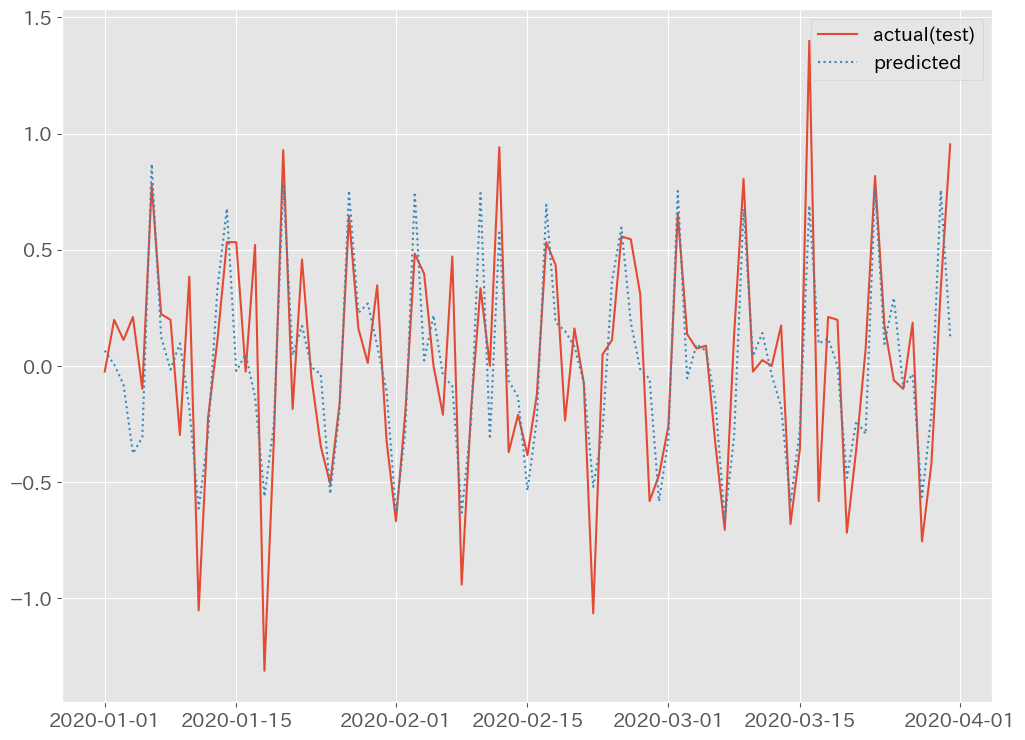

In [20]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    ridge_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


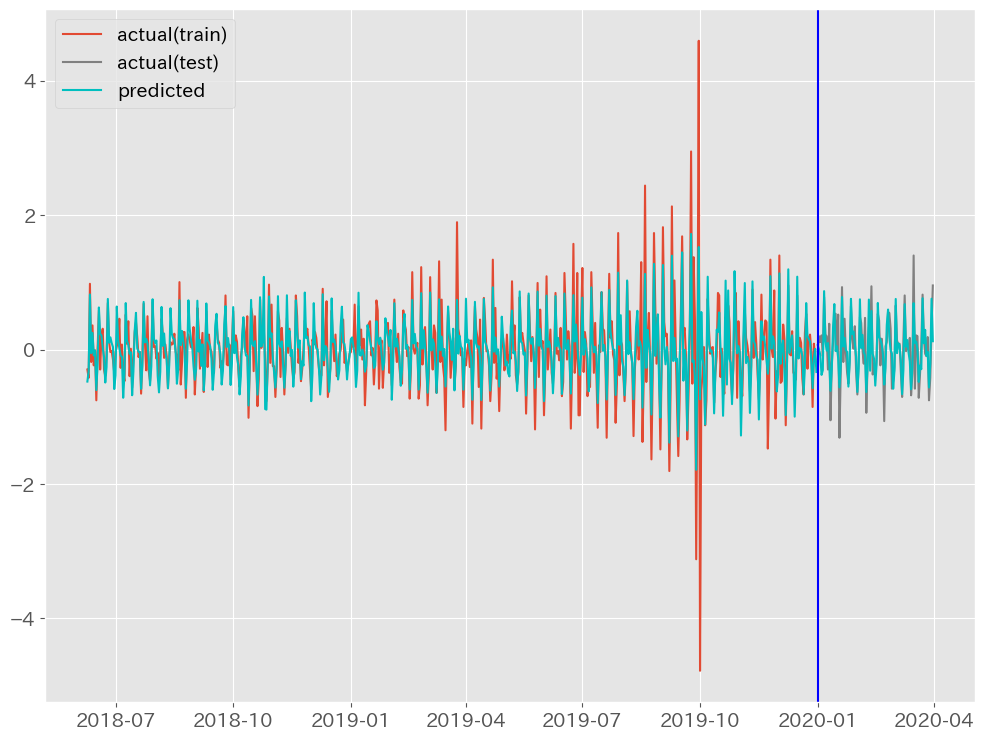

In [21]:
fig, ax = plt.subplots()
ax.plot(train.index, y_train, label='actual(train)')
ax.plot(test.index, y_test, label='actual(test)', color='gray')
ax.plot(train.index, train_pred, color='c')
ax.plot(test.index, ridge_pred, label="predicted", color="c") 
ax.axvline(datetime.datetime(2020,1,1),color='blue')
ax.legend()
plt.show()

# Lasso回帰

In [22]:
regressor = LassoCV(alphas=np.linspace(1, 10000000, 1000)/100, cv = 10)
regressor.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.00110090e+02, 2.00210180e+02, 3.00310270e+02,
       4.00410360e+02, 5.00510450e+02, 6.00610541e+02, 7.00710631e+02,
       8.00810721e+02, 9.00910811e+02, 1.00101090e+03, 1.10111099e+03,
       1.20121108e+03, 1.30131117e+03, 1.40141126e+03, 1.50151135e+03,
       1.60161144e+03, 1.70171153e+03, 1.80181162e+03, 1.90191171e+03,
       2.00201180e+03, 2.10211189e+0...
       9.76976979e+04, 9.77977980e+04, 9.78978981e+04, 9.79979982e+04,
       9.80980983e+04, 9.81981984e+04, 9.82982985e+04, 9.83983986e+04,
       9.84984986e+04, 9.85985987e+04, 9.86986988e+04, 9.87987989e+04,
       9.88988990e+04, 9.89989991e+04, 9.90990992e+04, 9.91991993e+04,
       9.92992994e+04, 9.93993995e+04, 9.94994995e+04, 9.95995996e+04,
       9.96996997e+04, 9.97997998e+04, 9.98998999e+04, 1.00000000e+05]),
        cv=10)

In [23]:
# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag7_new = y_train_new.iloc[-7] #lag1
    window7_new = y_train_new[-7:].mean() #window7
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),1] = lag1_new
    X_test.iloc[(i+1):(i+2),2] = lag7_new
    X_test.iloc[(i+1):(i+2),3] = window7_new
    X_test.iloc[(i+1):(i+2),4] = expanding_new
    
# 予測値の代入
lasso_pred = y_train_new[-91:]
    
# 更新後の説明変数X
print(X_test)

            call_num  acc_get_cnt_lag1  acc_get_cnt_lag7  acc_get_cnt_window7  \
cdr_date                                                                        
2020-01-01  0.000000         -0.235352          0.173340            -0.107910   
2020-01-02  0.000000          0.028849          0.222920            -0.128570   
2020-01-03  0.216919          0.014474         -0.037153            -0.158348   
2020-01-04 -0.216919         -0.031075         -0.854528            -0.157479   
2020-01-05  0.000000         -0.391843          0.086691            -0.091381   
...              ...               ...               ...                  ...   
2020-03-27  0.108459         -0.126331         -0.531661            -0.002616   
2020-03-28 -1.059570          0.029691         -0.199890             0.077577   
2020-03-29  0.000000         -0.615298         -0.327093             0.018233   
2020-03-30  1.118164         -0.206505          0.819503             0.035460   
2020-03-31 -0.275391        

In [24]:
print('決定係数（R2） = ', r2_score(y_test, lasso_pred).round(decimals=3))
print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, lasso_pred).round(decimals=3))
print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, lasso_pred).round(decimals=3))
print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, lasso_pred)).round(decimals=3))


決定係数（R2） =  0.603
平均絶対誤差（MAE） =  0.238
平均二乗誤差（MSE） =  0.093
平均二乗平方根誤差（RMSE） =  0.305


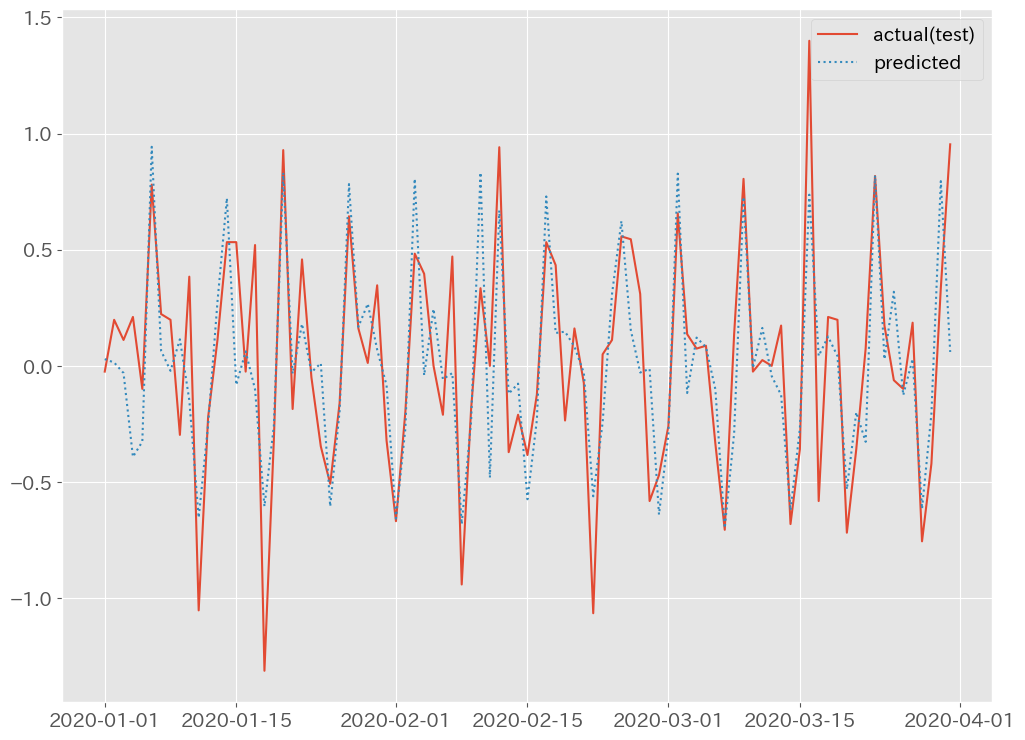

In [25]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    lasso_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


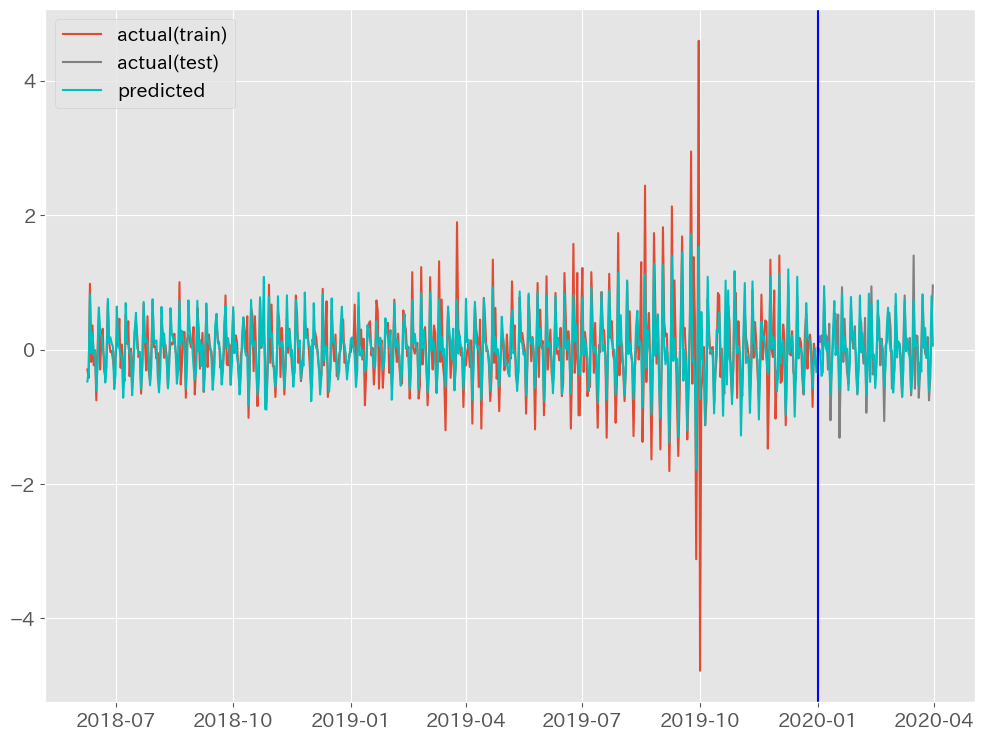

In [26]:
fig, ax = plt.subplots()
ax.plot(train.index, y_train, label='actual(train)')
ax.plot(test.index, y_test, label='actual(test)', color='gray')
ax.plot(train.index, train_pred, color='c')
ax.plot(test.index, lasso_pred, label="predicted", color="c") 
ax.axvline(datetime.datetime(2020,1,1),color='blue')
ax.legend()
plt.show()

# Elastic net回帰

In [27]:
regressor = ElasticNetCV(alphas=np.linspace(1, 10000000, 1000)/100, 
                         l1_ratio=np.linspace(0, 10000, 1000)/10000,
                         cv = 10)
regressor.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-02, 1.00110090e+02, 2.00210180e+02, 3.00310270e+02,
       4.00410360e+02, 5.00510450e+02, 6.00610541e+02, 7.00710631e+02,
       8.00810721e+02, 9.00910811e+02, 1.00101090e+03, 1.10111099e+03,
       1.20121108e+03, 1.30131117e+03, 1.40141126e+03, 1.50151135e+03,
       1.60161144e+03, 1.70171153e+03, 1.80181162e+03, 1.90191171e+03,
       2.00201180e+03, 2.102111...
       0.96596597, 0.96696697, 0.96796797, 0.96896897, 0.96996997,
       0.97097097, 0.97197197, 0.97297297, 0.97397397, 0.97497497,
       0.97597598, 0.97697698, 0.97797798, 0.97897898, 0.97997998,
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]))

In [28]:
train_pred = regressor.predict(X_train)

In [29]:
# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag7_new = y_train_new.iloc[-7] #lag1
    window7_new = y_train_new[-7:].mean() #window7
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),1] = lag1_new
    X_test.iloc[(i+1):(i+2),2] = lag7_new
    X_test.iloc[(i+1):(i+2),3] = window7_new
    X_test.iloc[(i+1):(i+2),4] = expanding_new
    
# 予測値の代入
elastic_pred = y_train_new[-91:]
    
# 更新後の説明変数X
print(X_test)

            call_num  acc_get_cnt_lag1  acc_get_cnt_lag7  acc_get_cnt_window7  \
cdr_date                                                                        
2020-01-01  0.000000         -0.235352          0.173340            -0.107910   
2020-01-02  0.000000          0.020941          0.222920            -0.129699   
2020-01-03  0.216919          0.058649         -0.037153            -0.153167   
2020-01-04 -0.216919         -0.016986         -0.854528            -0.150285   
2020-01-05  0.000000         -0.395661          0.086691            -0.084733   
...              ...               ...               ...                  ...   
2020-03-27  0.108459         -0.111582         -0.571142            -0.001820   
2020-03-28 -1.059570          0.031452         -0.203946             0.084265   
2020-03-29  0.000000         -0.671492         -0.318801             0.017472   
2020-03-30  1.118164         -0.186170          0.820250             0.036420   
2020-03-31 -0.275391        

In [30]:
print('決定係数（R2） = ', r2_score(y_test, elastic_pred).round(decimals=3))
print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, elastic_pred).round(decimals=3))
print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, elastic_pred).round(decimals=3))
print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, elastic_pred)).round(decimals=3))

決定係数（R2） =  0.612
平均絶対誤差（MAE） =  0.235
平均二乗誤差（MSE） =  0.091
平均二乗平方根誤差（RMSE） =  0.302


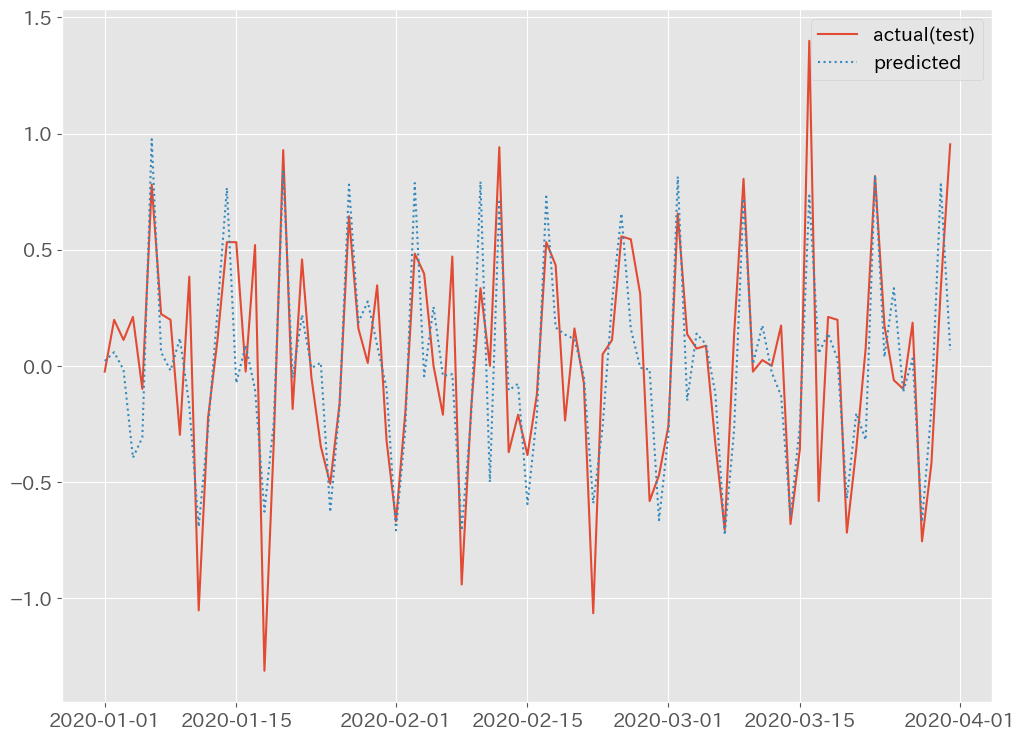

In [31]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index, 
    elastic_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


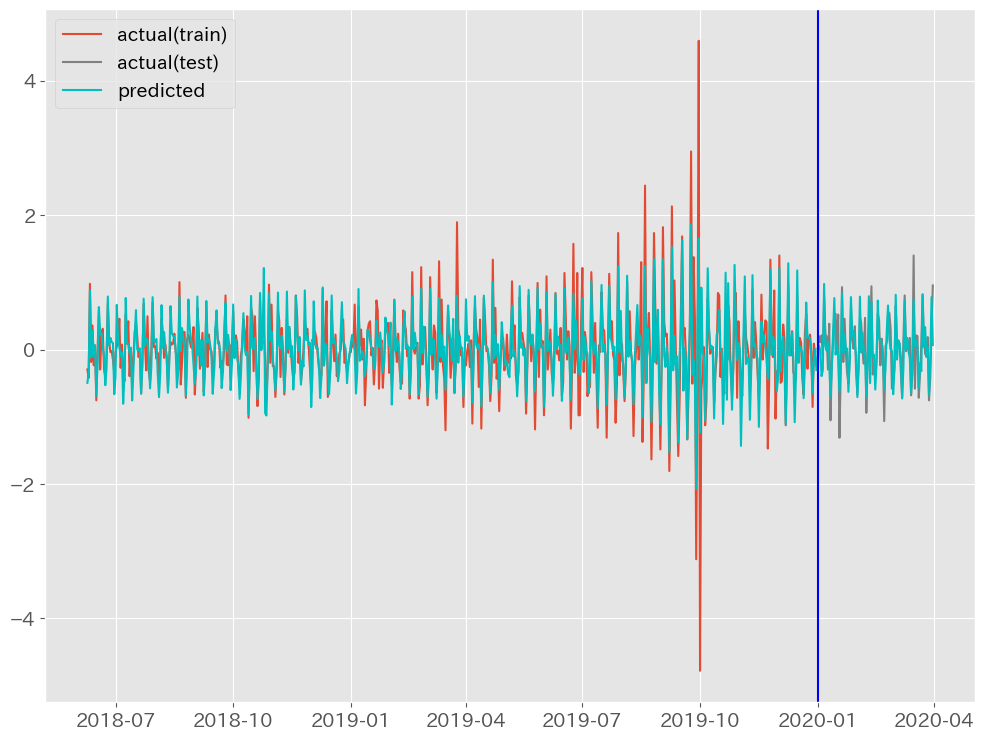

In [32]:
fig, ax = plt.subplots()
ax.plot(train.index, y_train, label='actual(train)')
ax.plot(test.index, y_test, label='actual(test)', color='gray')
ax.plot(train.index, train_pred, color='c')
ax.plot(test.index, elastic_pred, label="predicted", color="c") 
ax.axvline(datetime.datetime(2020,1,1),color='blue')
ax.legend()
plt.show()

In [33]:
#Ridge回帰とElasticNet回帰のアンサンブル
regression_pred = (ridge_pred+elastic_pred)/2
print(regression_pred)

2020-01-01    0.043166
2020-01-02    0.032250
2020-01-03   -0.048985
2020-01-04   -0.386361
2020-01-05   -0.307944
                ...   
2020-03-27   -0.002054
2020-03-28   -0.617860
2020-03-29   -0.197155
2020-03-30    0.768837
2020-03-31    0.095843
Length: 91, dtype: float64


In [34]:
print('決定係数（R2） = ', r2_score(y_test, regression_pred).round(decimals=3))
print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, regression_pred).round(decimals=3))
print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, regression_pred).round(decimals=3))
print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, regression_pred)).round(decimals=3))

決定係数（R2） =  0.615
平均絶対誤差（MAE） =  0.235
平均二乗誤差（MSE） =  0.09
平均二乗平方根誤差（RMSE） =  0.301


In [35]:
regression_pred_reset = regression_pred.reset_index()  # インデックスをリセットし、データフレームに変換する

# CSVファイルに書き出す
regression_pred_reset.to_csv('regression_pred.csv', index=False)  